Click this button to run in Colab.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ssuai/deep_learning_from_scratch/blob/master/ch06/initialization.ipynb)

In [1]:
# %load weight_init_activation_histogram.py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# some helper functions for Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False
    
if is_colab():
    !git clone --filter=blob:none --sparse https://github.com/ssuai/deep_learning_from_scratch.git
    %cd deep_learning_from_scratch
    !git sparse-checkout set dataset common ch06
else:
    import sys
    import os
    sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

In [4]:
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
#     w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
#     w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)  # Xavier
#     w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
#     z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

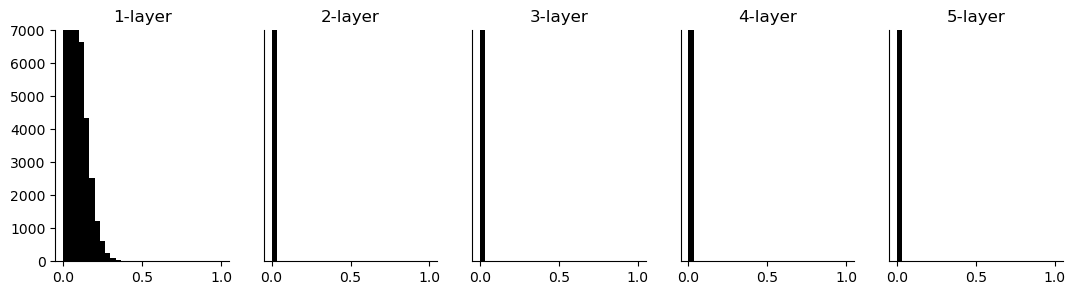

In [5]:
# 히스토그램 그리기
plt.figure(figsize=(13,3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1), color='k')
    sns.despine()

# plt.show()
plt.savefig('hist.png')

## 6.2.4 MNIST 데이터셋으로 본 가중치 초기값 비교

In [6]:
# %load weight_init_compare.py
# import os
# import sys

# sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
# import numpy as np
# import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))



===========iteration:0===========
std=0.01:2.3025218197064596
Xavier:2.3015907960966264
He:2.406747302670243
===========iteration:100===========
std=0.01:2.302521366369282
Xavier:2.2279720116862283
He:1.6794327979617059
===========iteration:200===========
std=0.01:2.302402281079286
Xavier:2.0391444776859733
He:0.8614019890868241
===========iteration:300===========
std=0.01:2.302958196714573
Xavier:1.6353430459643796
He:0.5754044355315848
===========iteration:400===========
std=0.01:2.300231880187132
Xavier:1.0908463710381138
He:0.4146560442034806
===========iteration:500===========
std=0.01:2.303755643342348
Xavier:0.6846010267853696
He:0.3545097313072321
===========iteration:600===========
std=0.01:2.304640100732966
Xavier:0.5933050842541006
He:0.35463160987352566
===========iteration:700===========
std=0.01:2.3066728776482206
Xavier:0.5883543507778717
He:0.4712527829862196
===========iteration:800===========
std=0.01:2.302477043425254
Xavier:0.46777820264495873
He:0.32723045158425745

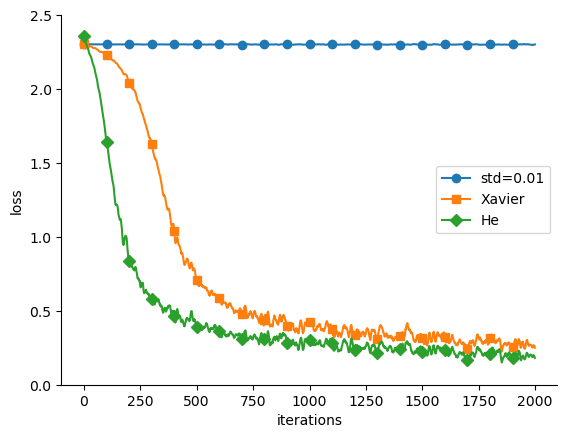

In [7]:
# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
# plt.show()
sns.despine()